# SP simulations for updated wellbore geometry

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize, SymLogNorm
from matplotlib import cm as colormap
from scipy.constants import foot, inch

import discretize
from discretize import utils
from simpeg.electromagnetics import frequency_domain as fdem
from simpeg import utils, maps, Report
import geoana

from pymatsolver import Pardiso

## Set up the model parameters

- all conductivity values are in units of S/m
- all length scales are in units of meters

In this example, rather than steel, it is replaced with cement 

In [2]:
conductivity_values = {
    "background":0.07,
    "cement":0.01,
    "cement_eap": 85, 
    "sand": 0.01,
    "steel": 0.01, #5e6
    "very_resistive":1e-8,
    "fluid":0.05,
    "break": 1e-8,
}

print("Conductivity values")
for key, val in conductivity_values.items():
    print(f"{key:15s}: {val:1.1e} S/m")


Conductivity values
background     : 7.0e-02 S/m
cement         : 1.0e-02 S/m
cement_eap     : 8.5e+01 S/m
sand           : 1.0e-02 S/m
steel          : 1.0e-02 S/m
very_resistive : 1.0e-08 S/m
fluid          : 5.0e-02 S/m
break          : 1.0e-08 S/m


In [3]:
geometry = {
    "casing_length": 11, # 9m, 30ft
    "surface_packer_thickness": 0.5, # 1.6ft
    "bottom_seal_thickness": 3,  # 10ft
    "casing_outer_diameter": 0.6, # 24in
    "casing_inner_diameter": 0.18, # 7in
    "pvc_outer_diameter": 0.04, # 1.5in
    "pvc_inner_diameter": 0.03, # 1.0in
    "break_top": 0, 
    "break_bottom": -2,
}
geometry["casing_outer_radius"] = geometry["casing_outer_diameter"] / 2
geometry["casing_inner_radius"] = geometry["casing_inner_diameter"] / 2
geometry["pvc_outer_radius"] = geometry["pvc_outer_diameter"] / 2
geometry["pvc_inner_radius"] = geometry["pvc_inner_diameter"] / 2
geometry["total_length"] = geometry["casing_length"] + geometry["bottom_seal_thickness"]

cement_depth = {
    "case_1": 9, # 50 ft
    # "case_2": 30, # 100 ft
    # "case_3": 7.5, # 25ft
}

print("Geometry")
for key, val in geometry.items():
    print(f"{key:25s}: {val:3.2f} m")
print("\nCement depth")
for key, val in cement_depth.items():
    print(f"{key:8s}: {val:2.1f} m")

Geometry
casing_length            : 11.00 m
surface_packer_thickness : 0.50 m
bottom_seal_thickness    : 3.00 m
casing_outer_diameter    : 0.60 m
casing_inner_diameter    : 0.18 m
pvc_outer_diameter       : 0.04 m
pvc_inner_diameter       : 0.03 m
break_top                : 0.00 m
break_bottom             : -2.00 m
casing_outer_radius      : 0.30 m
casing_inner_radius      : 0.09 m
pvc_outer_radius         : 0.02 m
pvc_inner_radius         : 0.01 m
total_length             : 14.00 m

Cement depth
case_1  : 9.0 m


## compute Jsp assuming steady-state flow

In [4]:
rho_water = 1000
g = 10 
L = 1e-5

pore_pressure_gradient = {
    "case_1": -2.5e5,
}

scaling = - L / (rho_water * g) 
scaling

print("Pore pressure gradient")
for key, val in pore_pressure_gradient.items():
    print(f"{key:8s}: {val:1.1e} Pa/m")

Pore pressure gradient
case_1  : -2.5e+05 Pa/m


In [5]:
pore_pressure_gradient["case_1"] * scaling

0.00025

In [6]:
jsp_values = {
    key: scaling * val for key, val in pore_pressure_gradient.items()
}

print("jsp")
for key, val in jsp_values.items():
    print(f"{key:8s}: {val:1.1e} A/m^2")

jsp
case_1  : 2.5e-04 A/m^2


In [7]:
currents = {
    key: val*(np.pi * (geometry['casing_inner_radius']**2 - geometry['pvc_outer_radius']**2)) for key, val in jsp_values.items()
}
for key, val in currents.items():
    print(f"{key}: {val: 1.1e} A")

case_1:  6.0e-06 A


# build a mesh

- we highly refine the mesh near the wellbore and then pad out to ensure that we satisfy boundary conditions (e.g. that the outer boundary is a few skin depths away)

In [8]:
csx = 0.0025
csz = 0.125
padding_factor = 1.1
npad_x = 120 #70 # 40
npad_z = 80 # 25

n_core_x = int(np.ceil(geometry["casing_outer_radius"]/csx))
n_core_z = int(np.ceil((geometry["total_length"])/csz))

In [9]:
mesh = discretize.CylindricalMesh(
    [
        [(csx, n_core_x), (csx, npad_x, padding_factor)],
        np.r_[2*np.pi], 
        [(csz, npad_z, -padding_factor), (csz, n_core_z), (csz, npad_z, padding_factor)]
    ]
)

mesh.origin = np.r_[0, 0, -mesh.h[2][:npad_z+n_core_z].sum()]

<AxesSubplot:xlabel='x', ylabel='z'>

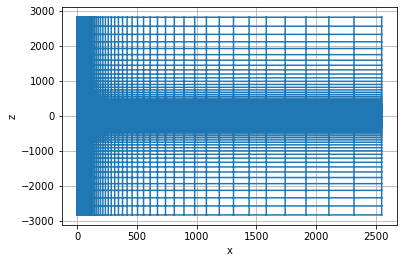

In [10]:
mesh.plot_grid()

In [11]:
print(mesh.n_cells)

65280


## put the model on the mesh

In [12]:
def get_model(case, eap=False, steel_conductivity=None, broken_casing=False): 
    """
    A function to put the electrical conductivity model on the mesh for each 
    of the different cases. 
    """
    
    if steel_conductivity is None: 
        steel_conductivity = conductivity_values["steel"]
    
    # initialize as background
    model = np.ones(mesh.n_cells) * conductivity_values["background"]

    # air
    model[mesh.cell_centers[:,2] > 0] = conductivity_values["very_resistive"]

    # steel casing
    inds_casing_z = (
        (mesh.cell_centers[:, 2] >= -geometry["casing_length"]) &
        (mesh.cell_centers[:, 2] <= 0)
    )
    inds_steel = (
        (mesh.cell_centers[:, 0] <= geometry["casing_outer_radius"]) & 
        (mesh.cell_centers[:, 0] >= geometry["casing_inner_radius"]) &
        inds_casing_z
    )
    if broken_casing is True: 
        inds_break_z = (
            (mesh.cell_centers[:, 2] < geometry["break_top"]) & 
            (mesh.cell_centers[:, 2] > geometry["break_bottom"])
        )
        model [inds_steel & inds_break_z] = conductivity_values["break"]
        inds_steel[inds_break_z] = False
    
    model[inds_steel] = steel_conductivity 

    # sand and cement 
    inds_x_cement = (mesh.cell_centers[:, 0] < geometry["casing_inner_radius"])
    inds_z_cement = (
        (mesh.cell_centers[:, 2] < 0) & 
        (mesh.cell_centers[:, 2] >= -cement_depth[case])
    )

    model[inds_x_cement & inds_casing_z] = conductivity_values["sand"]

    if eap is False: 
        model[inds_x_cement & inds_z_cement] = conductivity_values["cement"]
    elif eap is True:
        model[inds_x_cement & inds_z_cement] = conductivity_values["cement_eap"]

    # surface_packer 
    inds_surface_packer = (
        inds_x_cement & 
        (mesh.cell_centers[:, 2] < 0) & 
        (mesh.cell_centers[:, 2] >= -geometry["surface_packer_thickness"])
    )
    model[inds_surface_packer] = conductivity_values["very_resistive"]

    # pvc casing
    inds_pvc = (
        (mesh.cell_centers[:, 0] <= geometry["pvc_outer_radius"]) &
        inds_casing_z 
    )
    model[inds_pvc] = conductivity_values["very_resistive"]

    # fluid
    inds_fluid = (
        (mesh.cell_centers[:, 0] <= geometry["pvc_inner_radius"]) &
        inds_casing_z 
    )
    model[inds_fluid] = conductivity_values["fluid"]

    # bottom hole packer
    inds_bottom_packer = (
        (mesh.cell_centers[:, 0] < geometry["casing_outer_radius"]) & 
        (mesh.cell_centers[:, 2] >= -geometry["total_length"]) & 
        (mesh.cell_centers[:, 2] <= - geometry["casing_length"])
    )
    model[inds_bottom_packer] = conductivity_values["very_resistive"]

    return model

## create dictionaries to hold the various models

In [13]:
models_cement = {key: get_model(key, False) for key in cement_depth.keys()}
models_cement_eap = {key: get_model(key, True) for key in cement_depth.keys()}

model_wholespace = conductivity_values["background"] * np.ones(mesh.n_cells)
model_halfspace = model_wholespace.copy()
model_halfspace[mesh.cell_centers[:, 2] > 0] = conductivity_values["very_resistive"]

## plot the models


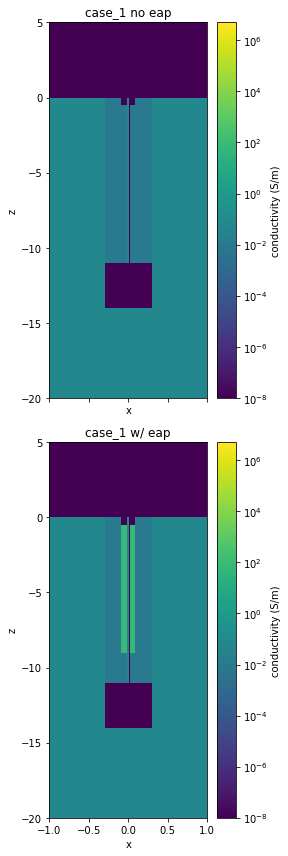

In [14]:
fig, ax = plt.subplots(2, len(jsp_values), figsize=(4*len(jsp_values), 12), sharex=True, sharey=True)

xlim = 1 * np.r_[-1, 1]
ylim = np.r_[-20, 5]

vmin = conductivity_values["very_resistive"]
vmax = 5e6 # conductivity_values["steel"]

for j, m in enumerate([models_cement[key], models_cement_eap[key]]): 
    cb = plt.colorbar(
        mesh.plot_image(
            m, ax=ax[j], mirror=True, pcolor_opts={"norm":LogNorm(vmin=vmin, vmax=vmax)}
        )[0], ax=ax[j]
    )
    cb.set_label("conductivity (S/m)")
    if j == 0: 
        ax[0].set_title(key + " no eap")
    elif j == 1: 
        ax[1].set_title(key + " w/ eap")
   

for a in ax.flatten(): 
    a.set_xlim(xlim)
    a.set_ylim(ylim)
plt.tight_layout()

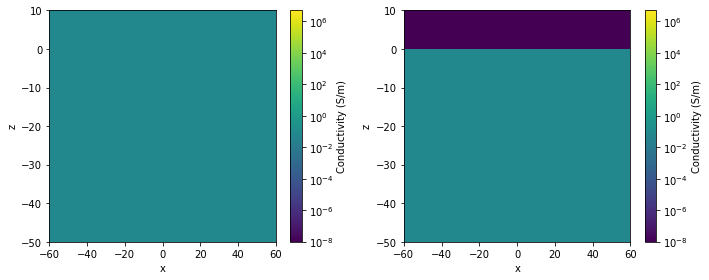

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

xlim = 60* np.r_[-1, 1]
ylim = np.r_[-50, 10]
 
for j, m in enumerate([model_wholespace, model_halfspace]): 
    cb = plt.colorbar(
        mesh.plot_image(
            m, ax=ax[j], mirror=True, pcolor_opts={"norm":LogNorm(vmin=vmin, vmax=vmax)}
        )[0], ax=ax[j]
    )
    cb.set_label("Conductivity (S/m)")
# ax[0, i].set_title(key)

for a in ax.flatten(): 
    a.set_xlim(xlim)
    a.set_ylim(ylim)
plt.tight_layout()

In [16]:
## put jsp on the mesh

In [17]:
def get_jsp(case): 
    """
    function to put jsp values on the vertical faces of the mesh. 
    """
    jsp_z = np.zeros(mesh.n_faces_z)
    inds_jsp = (
        (mesh.faces_z[:, 0] > geometry["pvc_outer_radius"]) & 
        (mesh.faces_z[:, 0] < geometry["casing_inner_radius"]) &
        (mesh.faces_z[:, 2] < -geometry["surface_packer_thickness"]) &
        (mesh.faces_z[:, 2] > -cement_depth[case]) 
    )
    jsp_z[inds_jsp] = jsp_values[case]

    return np.r_[np.zeros(mesh.n_faces_x), jsp_z]


In [18]:
jsp = {key: get_jsp(key) for key in jsp_values.keys()} 

## set up the simulations

Here, we use a frequency of 0.1Hz

In [19]:
freq = 1e-1

def get_sim(case):
    src = fdem.sources.RawVec_e([], frequency=freq, s_e=jsp[case])
    survey = fdem.survey.Survey([src])
    return fdem.simulation.Simulation3DMagneticField(
        mesh, survey=survey, sigmaMap=maps.IdentityMap(mesh), solver=Pardiso
    )

simulations = {key: get_sim(key) for key in cement_depth.keys()}

### run the simulations

In [20]:
fields_cement = {}
fields_cement_eap = {}

fields_wholespace = {}
fields_halfspace = {}

for key, sim in simulations.items(): 
    fields_cement[key] = sim.fields(models_cement[key])
    fields_cement_eap[key] = sim.fields(models_cement_eap[key])

    fields_wholespace[key] = sim.fields(model_wholespace)
    fields_halfspace[key] = sim.fields(model_halfspace)

In [21]:
### measure radial electric field data at the surface

In [22]:
dx = 2
surface_ex_inds = (
    (mesh.faces_x[:, 2] < 0) & (mesh.faces_x[:, 2] > -csz) & 
    (mesh.faces_x[:, 0] > dx)
)

surface_e_inds = np.r_[surface_ex_inds, np.zeros(mesh.n_faces_z, dtype=bool)]
x_data = mesh.nodes_x[mesh.nodes_x > dx]

In [23]:
# analytic solutions for wholespace 

def get_wholespace_solution(case): 
    inds_dipole = (
        (mesh.faces_z[:, 0] < csx) &
        (mesh.faces_z[:, 2] < -geometry["surface_packer_thickness"]) &
        (mesh.faces_z[:, 2] > -cement_depth[case]))
    
    dipole_locations = np.c_[np.zeros(inds_dipole.sum()), np.zeros(inds_dipole.sum()), mesh.faces_z[inds_dipole, 2]]
    
    e_analytic = np.zeros_like(x_data, dtype=complex)
    for i in range(dipole_locations.shape[0]):
        edipole = geoana.em.fdem.ElectricDipoleWholeSpace(
            frequency=freq, location=dipole_locations[i, :], length=csz, current=currents[case], 
            orientation="Z", sigma=conductivity_values["background"]
        )
        e_analytic = edipole.electric_field(np.c_[x_data, np.zeros_like(x_data), -csz/2*np.ones_like(x_data)])[:, 0] + e_analytic
    return e_analytic

In [24]:
e_analytic_wholespace = {
    key: get_wholespace_solution(key) for key in cement_depth.keys()
}

# plot results

Text(0.5, 1.0, 'Wholespace solutions')

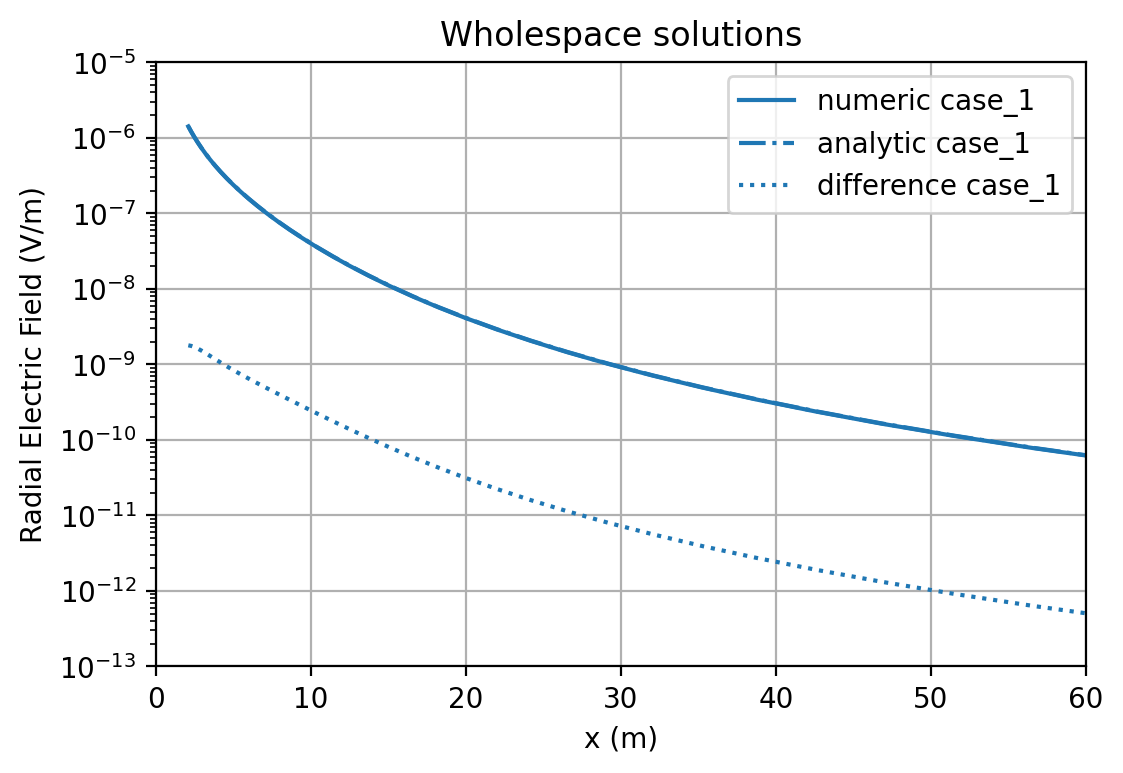

In [25]:
fig, ax = plt.subplots(1, 1, dpi=200)

xlim = np.r_[0, 60]
ylim = np.r_[1e-13, 1e-5]

for i, key in enumerate(e_analytic_wholespace.keys()):
    numeric = fields_wholespace[key][:, "e"][surface_e_inds].flatten()
    analytic = e_analytic_wholespace[key]
    ax.semilogy(x_data, numeric.real, color=f"C{i}", label=f"numeric {key}")
    ax.semilogy(x_data, analytic.real, "-.", color=f"C{i}", label=f"analytic {key}")
    ax.semilogy(x_data, (analytic.real - numeric.real), ":", color=f"C{i}", label=f"difference {key}")

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel("x (m)")
ax.set_ylabel("Radial Electric Field (V/m)")
ax.grid()
ax.legend()
ax.set_title("Wholespace solutions")


Text(0.5, 1.0, 'Wholespace solutions')

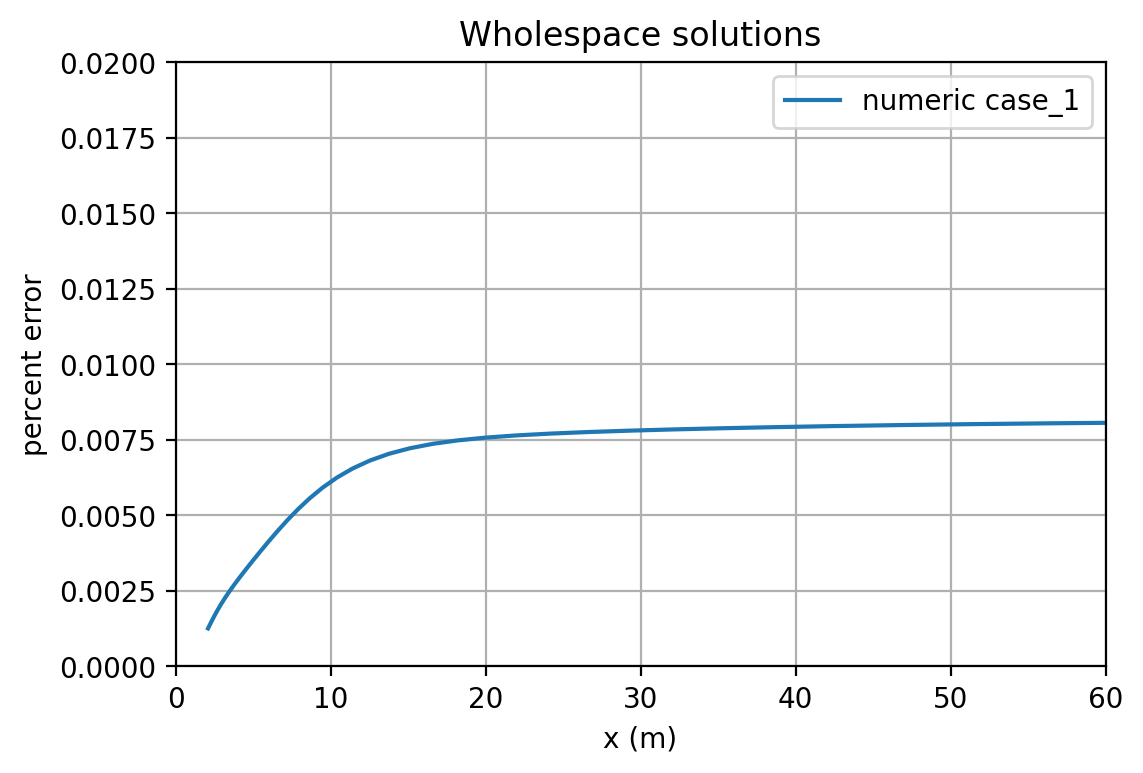

In [26]:
fig, ax = plt.subplots(1, 1, dpi=200)

xlim = np.r_[0, 60]
ylim = np.r_[1e-13, 1e-5]

for i, key in enumerate(e_analytic_wholespace.keys()):
    numeric = fields_wholespace[key][:, "e"][surface_e_inds].flatten()
    analytic = e_analytic_wholespace[key]
    ax.plot(x_data, np.abs(numeric.real-analytic.real)/analytic.real, color=f"C{i}", label=f"numeric {key}")
ax.set_xlim(xlim)
ax.set_ylim([0, 0.02])
ax.set_xlabel("x (m)")
ax.set_ylabel("percent error")
ax.grid()
ax.legend()
ax.set_title("Wholespace solutions")


Text(0.5, 1.0, 'Halfspace solutions')

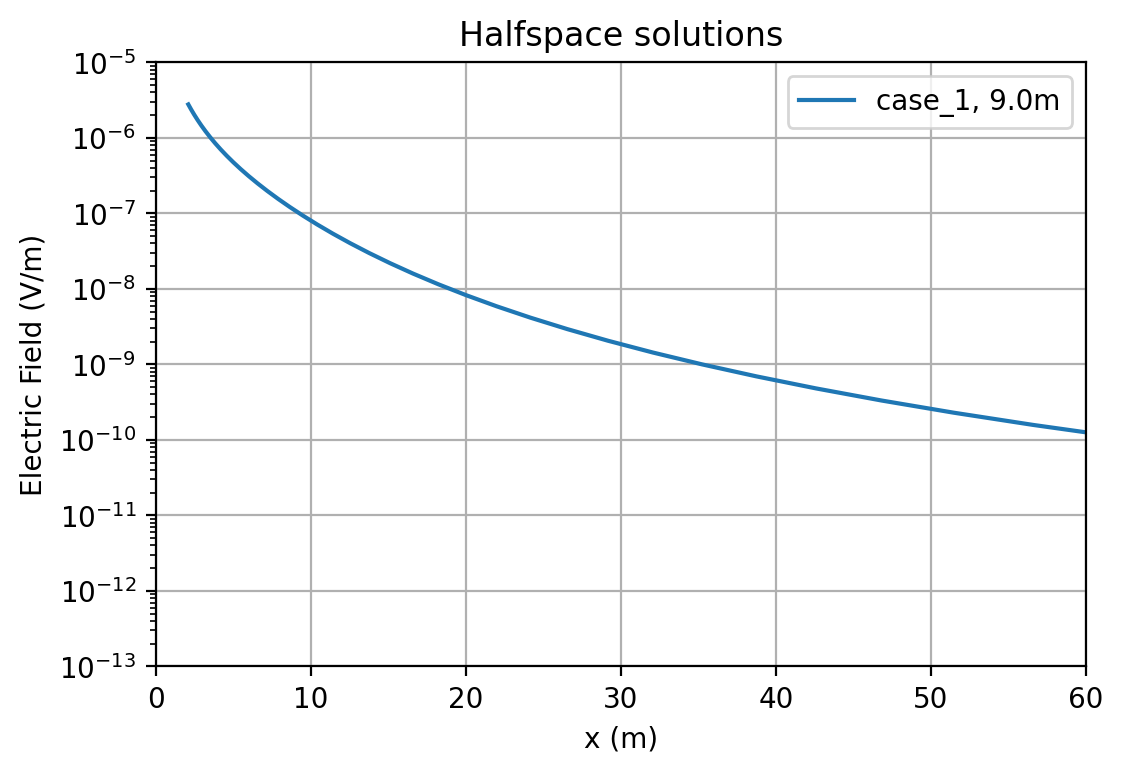

In [27]:
fig, ax = plt.subplots(1, 1, dpi=200)

xlim = np.r_[0, 60]
ylim = np.r_[1e-13, 1e-5]

for i, key in enumerate(fields_halfspace.keys()):
    numeric = fields_halfspace[key][:, "e"][surface_e_inds].flatten()
    ax.semilogy(x_data, numeric.real, color=f"C{i}", label=f"{key}, {cement_depth[key]:1.1f}m")

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel("x (m)")
ax.set_ylabel("Electric Field (V/m)")
ax.grid()
ax.legend()
ax.set_title("Halfspace solutions")

Text(0.5, 1.0, 'Casing models (1e-02 S/m)')

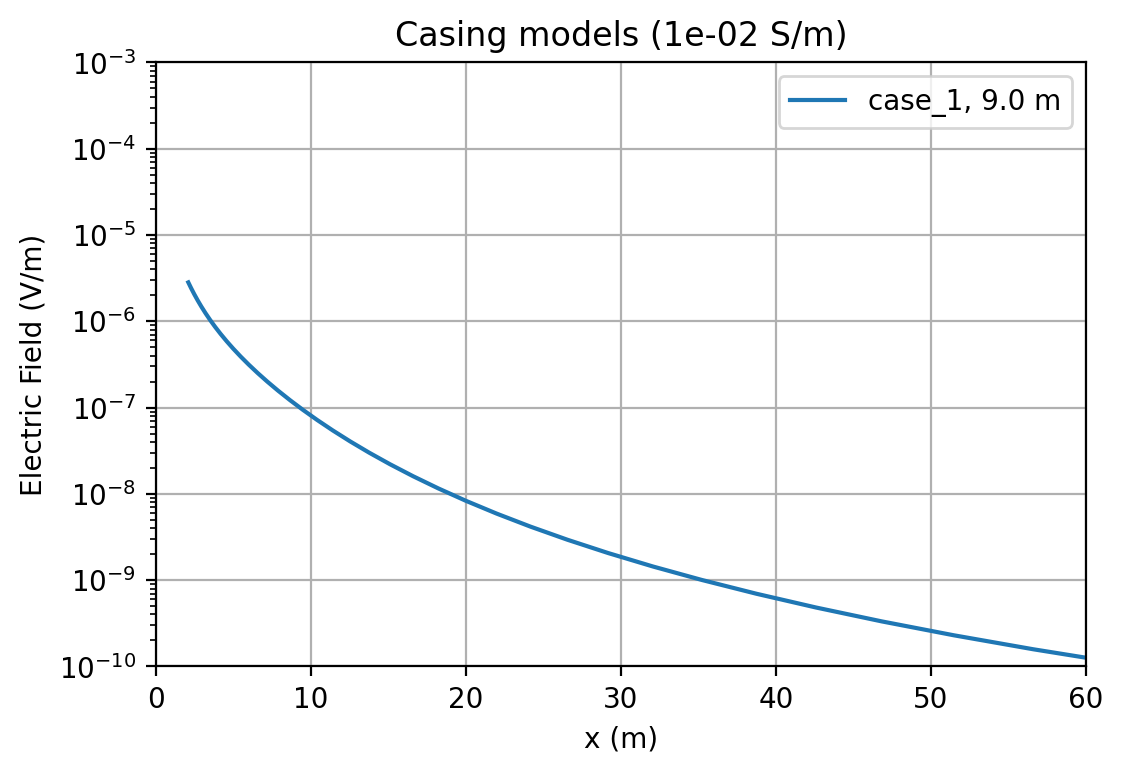

In [28]:
fig, ax = plt.subplots(1, 1, dpi=200)

xlim = np.r_[0, 60]
ylim = np.r_[1e-10, 1e-3]

i = 0
for key, val in fields_cement.items():
    ax.semilogy(x_data, np.abs(fields_cement[key][:, "e"][surface_e_inds].real), color=f"C{i}", label=f"{key}, {cement_depth[key]:1.1f} m")
    # ax.semilogy(x_data, np.abs(fields_cement_eap[key][:, "e"][surface_e_inds].real), "--", color=f"C{i}", label=f"{key}, {cement_depth[key]:1.1f} m, w/ eap")
    i = i+1

ax.legend()
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel("x (m)")
ax.set_ylabel("Electric Field (V/m)")
ax.grid()
ax.set_title(f"Casing models ({conductivity_values['steel']:1.0e} S/m)")

### measure data in an adjacent monitor well 

In [29]:
def get_borehole_inds(x_borehole, borehole_length=200): 
    ztop = -1
    borehole_ez_inds = (
        (mesh.faces_z[:, 0] < x_borehole + csx/2) & 
        (mesh.faces_z[:, 0] > x_borehole - csx/2) &
        (mesh.faces_z[:, 2] < ztop) & 
        (mesh.faces_z[:, 2] > -borehole_length)
    )
    borehole_e_inds = np.r_[
        np.zeros(mesh.n_faces_x, dtype=bool), borehole_ez_inds
    ]
    z_data = np.unique(mesh.faces_z[borehole_ez_inds, 2])
    print(np.unique(mesh.faces_z[borehole_ez_inds, 0]))
    return borehole_e_inds, z_data

In [30]:
x_inds_borehole = [174, 181]  # indices of the borehole
borehole_x = mesh.cell_centers_x[x_inds_borehole]
label_vals = np.round(borehole_x, 0)
print(f"Borehole locations: {label_vals}")

Borehole locations: [ 5. 10.]


In [31]:
borehole_inds = []

for x in borehole_x: 
    inds, z_data = get_borehole_inds(x)
    borehole_inds.append(inds)


[5.23530249]
[9.94359808]


Text(0.5, 1.0, 'Casing models (1e-02 S/m)')

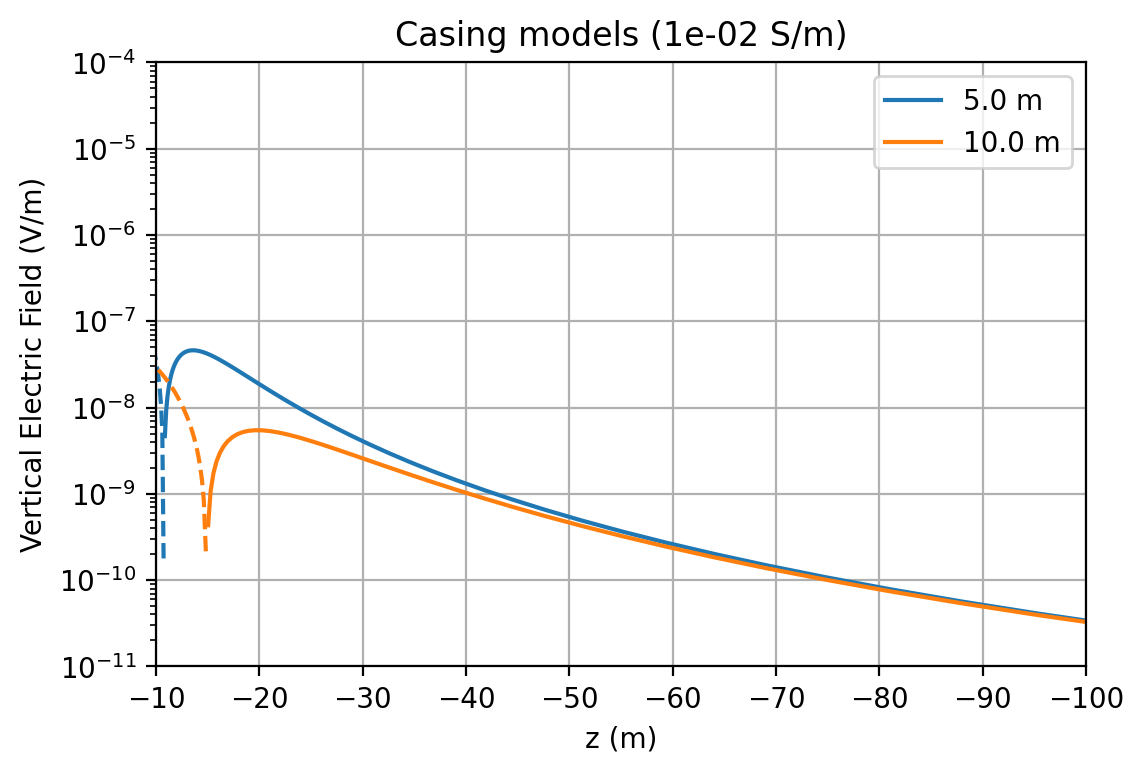

In [32]:
fig, ax = plt.subplots(1, 1, dpi=200)

xlim = np.r_[-10, -100]
ylim = np.r_[1e-11, 1e-4]
i=0

for i, inds in enumerate(borehole_inds): 
    label = f"{label_vals[i]} m"
    numeric = fields_cement[key][:, "e"][inds].flatten().real 
    inds_pos = numeric > 0
    inds_neg = ~inds_pos
    ax.semilogy(z_data[inds_pos], numeric[inds_pos], color=f"C{i}", ls="-", label=label)
    ax.semilogy(z_data[inds_neg], np.abs(numeric[inds_neg]), color=f"C{i}", ls="--")


ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel("z (m)")
ax.set_ylabel("Vertical Electric Field (V/m)")
ax.grid()
ax.legend()
ax.set_title(f"Casing models ({conductivity_values['steel']:1.0e} S/m)")


## plot magnetic fields

In [33]:
# plot magnetic fields 

borehole_mag_inds = [54, 62]
length = 200 
magnetic_field_r = mesh.nodes_x[mesh.nodes_x > geometry["casing_outer_radius"]][borehole_mag_inds]  # 1 cell outside of casing

inds_magnetic_field_data = [(
    (mesh.edges_y[:, 0] == r) &
    (mesh.edges_y[:, 2] < 0) & 
    (mesh.edges_y[:, 2] > -length)
) for r in magnetic_field_r]

magnetic_field_z = mesh.nodes_z[
    (mesh.nodes_z < 0) & 
    (mesh.nodes_z > -length)
]

print(magnetic_field_r)

[ 4.99897856 10.40412656]


In [34]:
def get_wholespace_b_fields(case, magnetic_field_r): 
    inds_dipole = (
        (mesh.faces_z[:, 0] < csx) &
        (mesh.faces_z[:, 2] < -geometry["surface_packer_thickness"]) &
        (mesh.faces_z[:, 2] > -cement_depth[case])
    )
    
    dipole_locations = np.c_[np.zeros(inds_dipole.sum()), np.zeros(inds_dipole.sum()), mesh.faces_z[inds_dipole, 2]]
    
    b_analytic = np.zeros_like(magnetic_field_z, dtype=complex)
    for i in range(dipole_locations.shape[0]):
        edipole = geoana.em.fdem.ElectricDipoleWholeSpace(
            frequency=freq, location=dipole_locations[i, :], length=csz, current=currents[case], 
            orientation="Z", sigma=conductivity_values["background"]
        )
        b_analytic = edipole.magnetic_flux_density(np.c_[magnetic_field_r*np.ones_like(magnetic_field_z), np.zeros_like(magnetic_field_z), magnetic_field_z])[:, 1] + b_analytic
    return b_analytic

In [35]:
b_analytic_wholespace = [
    get_wholespace_b_fields("case_1", r) for r in magnetic_field_r
]

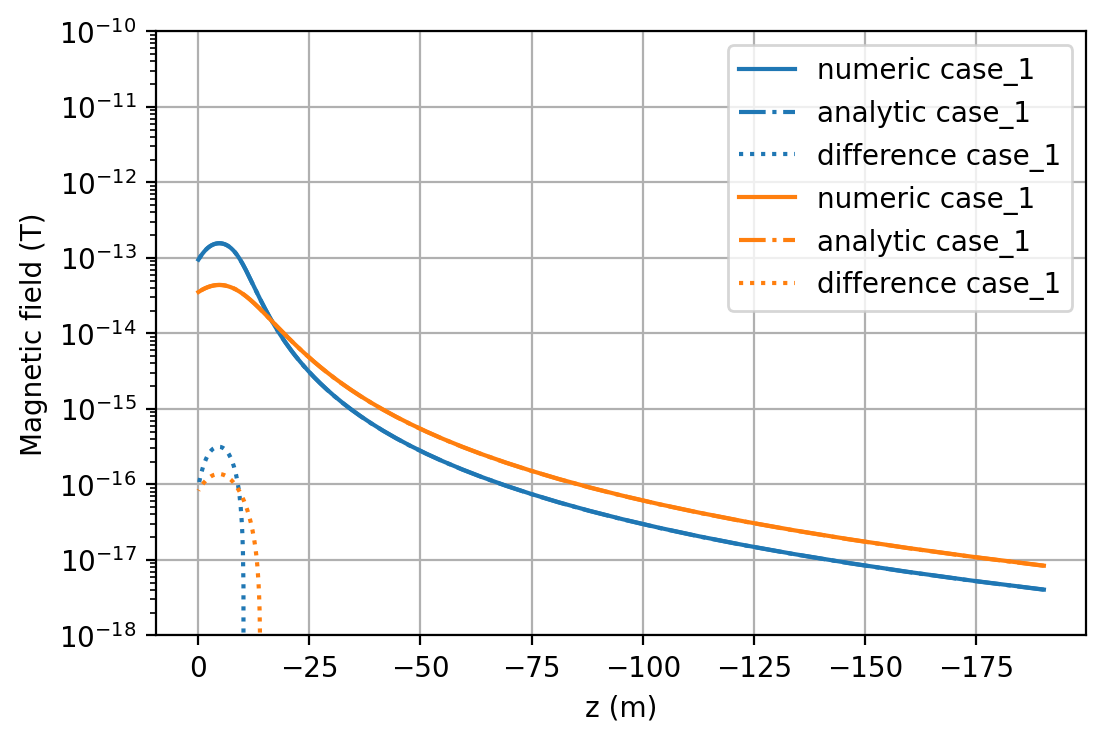

In [36]:
fig, ax = plt.subplots(1, 1, dpi=200)

xlim = np.r_[0, 60]
ylim = np.r_[1e-18, 1e-10]
key = "case_1"

for i, inds in enumerate(inds_magnetic_field_data):
    numeric = fields_wholespace[key][:, "b"][inds].flatten()
    analytic = b_analytic_wholespace[i]
    ax.semilogy(magnetic_field_z, np.abs(numeric.real), color=f"C{i}", label=f"numeric {key}")
    ax.semilogy(magnetic_field_z, analytic.real, "-.", color=f"C{i}", label=f"analytic {key}")
    ax.semilogy(magnetic_field_z, (analytic.real - numeric.real), ":", color=f"C{i}", label=f"difference {key}")

# ax.set_xlim(xlim)
ax.invert_xaxis()
ax.set_ylim(ylim)
ax.set_xlabel("z (m)")
ax.set_ylabel("Magnetic field (T)")
ax.grid()
ax.legend()
# ax.set_title(f"Wholespace solutions r={magnetic_field_r:1.2f}m")


Text(0.5, 1.0, 'Halfspace solutions')

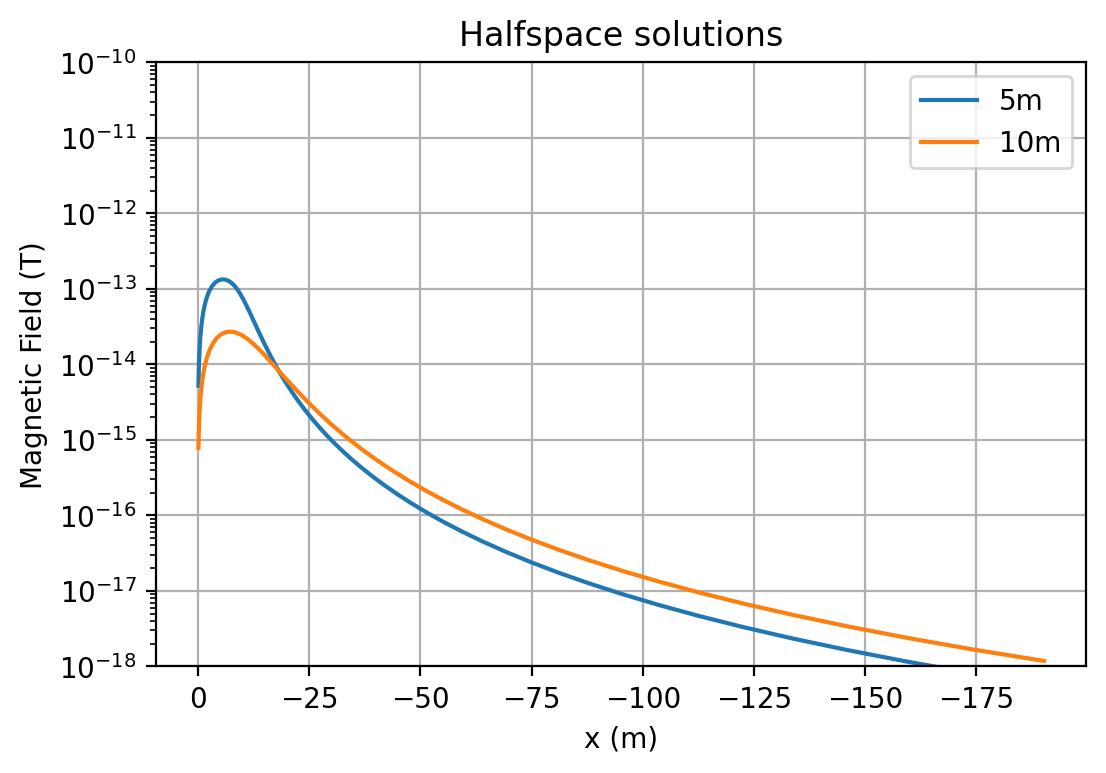

In [37]:
fig, ax = plt.subplots(1, 1, dpi=200)

# xlim = np.r_[0, 60]
ylim = np.r_[1e-18, 1e-10]

for i, inds in enumerate(inds_magnetic_field_data):
    numeric = fields_halfspace[key][:, "b"][inds].flatten()
    ax.semilogy(magnetic_field_z, np.abs(numeric.real), color=f"C{i}", label=f"{magnetic_field_r[i]:1.0f}m")

# ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.invert_xaxis()
ax.set_xlabel("x (m)")
ax.set_ylabel("Magnetic Field (T)")
ax.grid()
ax.legend()
ax.set_title(f"Halfspace solutions")

Text(0.5, 1.0, 'B$_y$ Casing models')

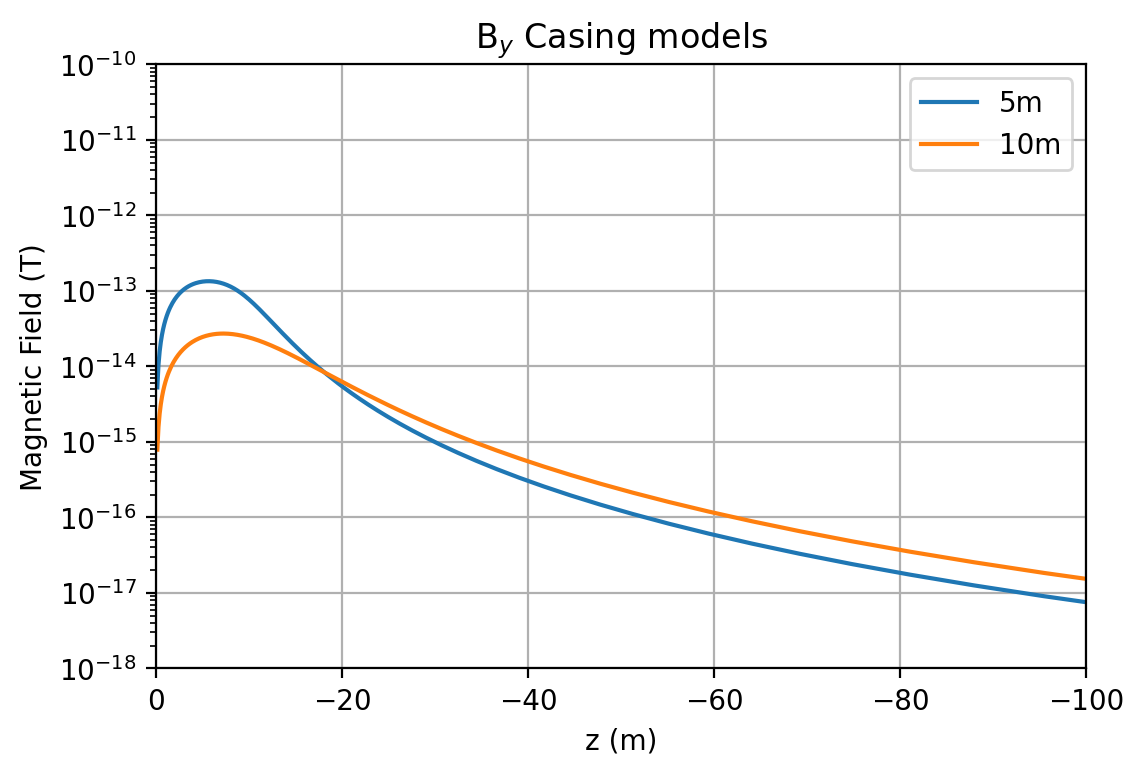

In [38]:
fig, ax = plt.subplots(1, 1, dpi=200)

xlim = np.r_[0, -100]
ylim = np.r_[1e-18, 1e-10]

for i, inds in enumerate(inds_magnetic_field_data):
    ax.semilogy(magnetic_field_z, np.abs(fields_cement[key][:, "b"][inds].real), color=f"C{i}", label=f"{magnetic_field_r[i]:1.0f}m")
    
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel("z (m)")
ax.set_ylabel("Magnetic Field (T)")
ax.grid()
ax.legend()
ax.set_title(f"B$_y$ Casing models")

In [39]:
Report()

--------------------------------------------------------------------------------
  Date: Wed Jan 08 10:39:17 2025 PST

                OS : Linux
            CPU(s) : 48
           Machine : x86_64
      Architecture : 64bit
               RAM : 125.8 GiB
       Environment : Jupyter
       File system : ext4

  Python 3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:39:03)
  [GCC 11.3.0]

            simpeg : 0.21.2.dev26+gd3f3a8407
        discretize : 0.8.4.dev11+gd5a27bf5
       pymatsolver : 0.2.0
             numpy : 1.22.4
             scipy : 1.9.0
           sklearn : 1.1.2
        matplotlib : 3.5.2
           empymod : 2.2.0
            geoana : 0.4.0
            pandas : 1.4.3
            cython : 0.29.32
            pydiso : 0.0.3
             numba : 0.55.2
              dask : 2022.8.0
             sympy : 1.13.0
           IPython : 8.4.0
        ipywidgets : 7.7.1
               utm : Version unknown
--------------------------------------------------------------------------------